# Implementation of Perelson et al.

In this implementation we're going to implement a [dynamical model](http://science.sciencemag.org/content/271/5255/1582), and evaluate it's properties.

In [2]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### (1) Reproduce all four panels from Figure 1 shown in Perelson et al. using eq. 6

Since we are not given any empirical data, use the fitted parameters and the appropriate constants to generate the curves shown on these plots. Remember to account for the time delays for each patient.

#### (i) Implement eq. 6 from the paper as a function.

__Variables:__

`V_total` ~ $V$ = total plasma concentration of virions
    
`V_I` ~ $V_I$ = plasma concentration of virions in the infectious pool
    
`V_NI` ~ $V_{NI}$ = plasma concentration of virions in the noninfectious pool
        
`T_star` ~ $T^*$ = productively infected cells

`T` ~ $T$ = Target cells

__Constants:__

_Measured Constants:_
    
`V_0` ~ $V_0$ = plasma concentration of virions in the infectious pool produced before drug effect
    
`T_0` ~ $T_0$ = quasi-steady state system of Target cells
        
`N` ~ $N$ = number of new virions produced per infected cells during its lifetime
        
_Rate Constants:_
    
`k_infection` ~ $k$ = rate constant at which HIV-1 infects Target cells ($\frac{mL}{virion\,\times\,day}$)
    
`delta_loss` ~ $\delta$ = rate constant of loss of virus producing cells ($day^{-1}$) 
        
`c_clearance` ~ $c$ = rate constant for virion clearance ($day^{-1}$)    

In [3]:
# parameter_array_V0_cClearance_deltaLoss = [V_0, c_clearance, delta_loss]

def V_total_from_eq_6(t_time, parameter_array_V0_cClearance_deltaLoss):
    
    V_0 = parameter_array_V0_cClearance_deltaLoss[0]
    c_clearance = parameter_array_V0_cClearance_deltaLoss[1]
    delta_loss = parameter_array_V0_cClearance_deltaLoss[2]
    
    exp_negative_c_times_t = np.exp(-1 * c_clearance * t_time)
    negative_delta_times_t = -1* delta_loss * t_time
    exp_negative_delta_times_t = np.exp(negative_delta_times_t)
    c_over_c_minus_delta = c_clearance / (c_clearance - delta_loss)
    
    V_total = (V_0 * exp_negative_c_times_t) + (V_0 * c_over_c_minus_delta) * (c_over_c_minus_delta * (exp_negative_delta_times_t - exp_negative_c_times_t) + (negative_delta_times_t * exp_negative_c_times_t))
    
    return(V_total)

patient_104_parameter_array = [(52 * 10**3), 3.68, 0.50]
patient_105_parameter_array = [(643 * 10**3), 2.06, 0.53]
patient_107_parameter_array = [(77 * 10**3), 3.09, 0.50]

assert(patient_104_parameter_array[0] == V_total_from_eq_6(0, patient_104_parameter_array))
assert(patient_105_parameter_array[0] == V_total_from_eq_6(0, patient_105_parameter_array))
assert(patient_107_parameter_array[0] == V_total_from_eq_6(0, patient_107_parameter_array))

#### (ii) Make the plot from this function's values over time.

Note that some constants are given in other papers published by this lab. An estimate of k, the viral infectivity rate, can be found in Wein et al. (J. Theor. Biol. 192:81-98) to be $3.43\times10^{-8}$ mL/(virion•day). Note that you will need to solve ordinary differential equations for T*, VI, and VNI to reproduce the data in Figure 1.

In [4]:
days = np.linspace(start=0, stop=8, num=9)

patient_104_delay = (2/24) # in days
patient_104_days = np.linspace(start=0+(patient_104_delay), stop=8, num=1000)
patient_105_delay = (6/24) # in days
patient_105_days = np.linspace(start=0+(patient_105_delay), stop=8, num=1000)
patient_107_delay = (2/24) # in days
patient_107_days = np.linspace(start=0+(patient_107_delay), stop=8, num=1000)

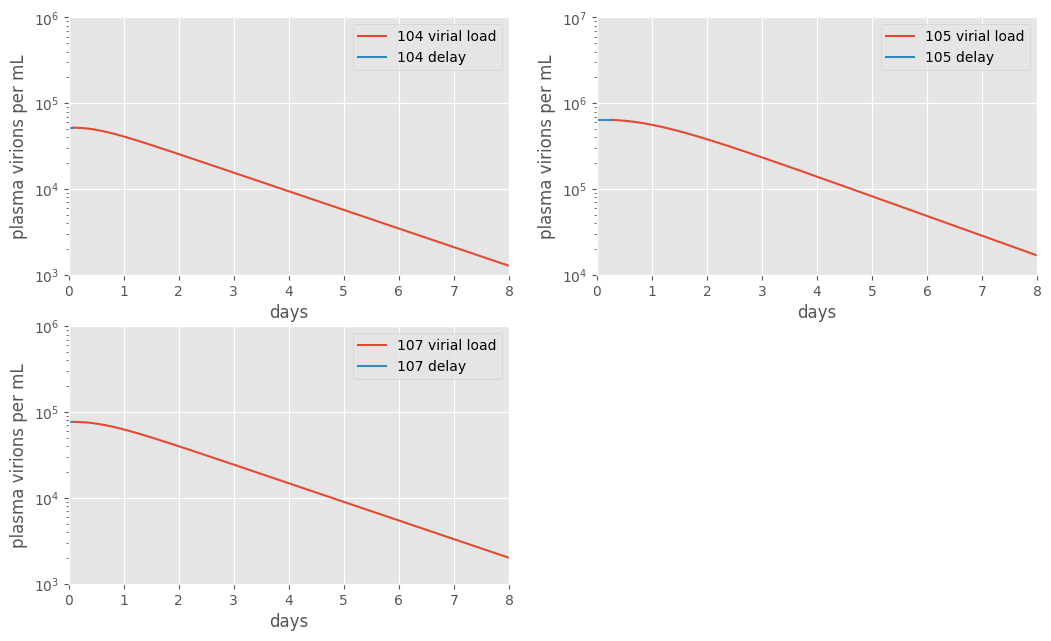

In [5]:
plt.figure(1, figsize=(12.5, 7.5), dpi=100)

plt.subplot(2,2,1)
plt.plot(patient_104_days, V_total_from_eq_6(patient_104_days, patient_104_parameter_array), label="104 virial load")
plt.plot([0,patient_104_delay], [patient_104_parameter_array[0], patient_104_parameter_array[0]], label="104 delay")
plt.ylim(10**3, 10**6)
plt.xlim(0, 8)
plt.yscale('log')
plt.ylabel('plasma virions per mL')
plt.xlabel('days')
plt.legend()

plt.subplot(2,2,2)
plt.plot(patient_105_days, V_total_from_eq_6(patient_105_days, patient_105_parameter_array), label="105 virial load")
plt.plot([0,patient_105_delay], [patient_105_parameter_array[0], patient_105_parameter_array[0]], label="105 delay")
plt.ylim(10**4, 10**7)
plt.xlim(0, 8)
plt.yscale('log')
plt.ylabel('plasma virions per mL')
plt.xlabel('days')
plt.legend()

plt.subplot(2,2,3)
plt.plot(patient_107_days, V_total_from_eq_6(patient_107_days, patient_107_parameter_array), label="107 virial load")
plt.plot([0,patient_107_delay], [patient_107_parameter_array[0], patient_107_parameter_array[0]], label="107 delay")
plt.ylim(10**3, 10**6)
plt.xlim(0, 8)
plt.yscale('log')
plt.ylabel('plasma virions per mL')
plt.xlabel('days')
plt.legend()

plt.show()

### (2) Reimplement the model relaxing the assumption about T remaining constant by numerically solving the system of ODEs.

#### i. Define a function that takes each parameter as a vector and outputs the time derivative of each species.

In [6]:
from sympy import Symbol, nsolve
import sympy
import mpmath

patient_104_parameter_array_expanded = [(52 * 10**3), 3.68, 0.50, 2, (3.43 * 10**(-8))]
patient_105_parameter_array_expanded = [(643 * 10**3), 2.06, 0.53, 11, (3.43 * 10**(-8))]
patient_107_parameter_array_expanded = [(77 * 10**3), 3.09, 0.50, 412, (3.43 * 10**(-8))]

def steady_state_solver(parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection):

    V_0 = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection[0]
    c_clearance = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection[1]
    delta_loss = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection[2]
    T_total = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection[3]
    k_infection = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection[4]

    T_star_steady = Symbol('T_star_steady')
    T_steady = Symbol('T_steady')
    N = Symbol('N')

    eq1 = k_infection*V_0*T_steady - delta_loss*T_star_steady
    eq2 = N*delta_loss*T_star_steady - c_clearance*V_0
    eq3 = T_total-T_star_steady-T_steady
    
    steady_state_array_Tstarsteady_Tsteady_N = np.asarray(nsolve((eq1, eq2, eq3), (T_star_steady,T_steady,N), (5,5,10**9)), dtype='float')
    
    return(steady_state_array_Tstarsteady_Tsteady_N)

steady_state_array_Tstarsteady_Tsteady_V0_104 = steady_state_solver(patient_104_parameter_array_expanded)[:2]
steady_state_array_Tstarsteady_Tsteady_V0_105 = steady_state_solver(patient_105_parameter_array_expanded)[:2]
steady_state_array_Tstarsteady_Tsteady_V0_107 = steady_state_solver(patient_107_parameter_array_expanded)[:2]

steady_state_array_Tstarsteady_Tsteady_V0_104 = np.append(steady_state_array_Tstarsteady_Tsteady_V0_104, [patient_104_parameter_array_expanded[0], 0])
steady_state_array_Tstarsteady_Tsteady_V0_105 = np.append(steady_state_array_Tstarsteady_Tsteady_V0_105, [patient_105_parameter_array_expanded[0], 0])
steady_state_array_Tstarsteady_Tsteady_V0_107 = np.append(steady_state_array_Tstarsteady_Tsteady_V0_107, [patient_107_parameter_array_expanded[0], 0])

patient_104_parameter_array_expanded.append(steady_state_solver(patient_104_parameter_array_expanded)[2])
patient_105_parameter_array_expanded.append(steady_state_solver(patient_105_parameter_array_expanded)[2])
patient_107_parameter_array_expanded.append(steady_state_solver(patient_107_parameter_array_expanded)[2])

print(steady_state_array_Tstarsteady_Tsteady_V0_105)
print(patient_105_parameter_array_expanded)
assert(steady_state_array_Tstarsteady_Tsteady_V0_105[0] 
       + steady_state_array_Tstarsteady_Tsteady_V0_105[1] 
       == patient_105_parameter_array_expanded[3]) # checking that the T_total sum is still working

[  4.39456112e-01   1.05605439e+01   6.43000000e+05   0.00000000e+00]
[643000, 2.06, 0.53, 11, 3.43e-08, 5687046.962279154]


In [7]:
# vars_array_Tstar_T_VI_VNI = [T_star, T, V_I, V_NI]
# parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N = [V0, c_clearance, delta_loss, T_total, k_infection, N]

def systemPostDrug(vars_array_Tstar_T_VI_VNI, t_time, parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N):
    
    T_star = vars_array_Tstar_T_VI_VNI[0]
    T = vars_array_Tstar_T_VI_VNI[1]
    V_I = vars_array_Tstar_T_VI_VNI[2]
    V_NI = vars_array_Tstar_T_VI_VNI[3]
    
    c_clearance = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N[1]
    delta_loss = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N[2]
    T_total = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N[3]
    k_infection = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N[4]
    N = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N[5]
    
    
    d_T_star__d_t = (k_infection * V_I * T) - (delta_loss * T_star)
    
    d_T__d_t = (-1 * d_T_star__d_t)
    
    d_V_I__d_t = (-1 * c_clearance * V_I)
    
    d_V_NI__d_t = (N * delta_loss * T_star) - (c_clearance * V_NI)
    
    
    d_vars_array_Tstar_T_VI_VNI__dt = [d_T_star__d_t, d_T__d_t, d_V_I__d_t, d_V_NI__d_t]
    
    return(d_vars_array_Tstar_T_VI_VNI__dt)

#### ii. Use odeint to solve this system of equations numerically for patient 105.

Hint: For ease later, it may be helpful to make a function here that handles everything but takes in gnu.

In [8]:
# vars_array_Tstar_T_VI_VNI = [T_star, T, V_I, V_NI]
# parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N = [V0, c_clearance, delta_loss, T_total, k_infection, N]
# steady_state_array_Tstarsteady_Tsteady_V0 = [T_star_steady, T_steady, V0, 0]

from scipy.integrate import odeint
sol105 = odeint(systemPostDrug, 
             steady_state_array_Tstarsteady_Tsteady_V0_105, 
             patient_105_days, 
             args=(patient_105_parameter_array_expanded,))

sol104 = odeint(systemPostDrug, 
             steady_state_array_Tstarsteady_Tsteady_V0_104, 
             patient_104_days, 
             args=(patient_104_parameter_array_expanded,))

sol107 = odeint(systemPostDrug, 
             steady_state_array_Tstarsteady_Tsteady_V0_107, 
             patient_107_days, 
             args=(patient_107_parameter_array_expanded,))

patientTtotal105 = [sum(x) for x in zip(sol105[:, 0],sol105[:, 1])]
print(np.sum(np.divide(patientTtotal105, patient_105_parameter_array_expanded[3])))
print(len(patientTtotal105)) # checking my sanity, these two values should be equal

patient105VirialLoad = [sum(x) for x in zip(sol105[:, 2],sol105[:, 3])]
patient104VirialLoad = [sum(x) for x in zip(sol104[:, 2],sol104[:, 3])]
patient107VirialLoad = [sum(x) for x in zip(sol107[:, 2],sol107[:, 3])]

1000.0
1000


#### iii. Reproduce the subpanels of Fig. 1 with this updated model.

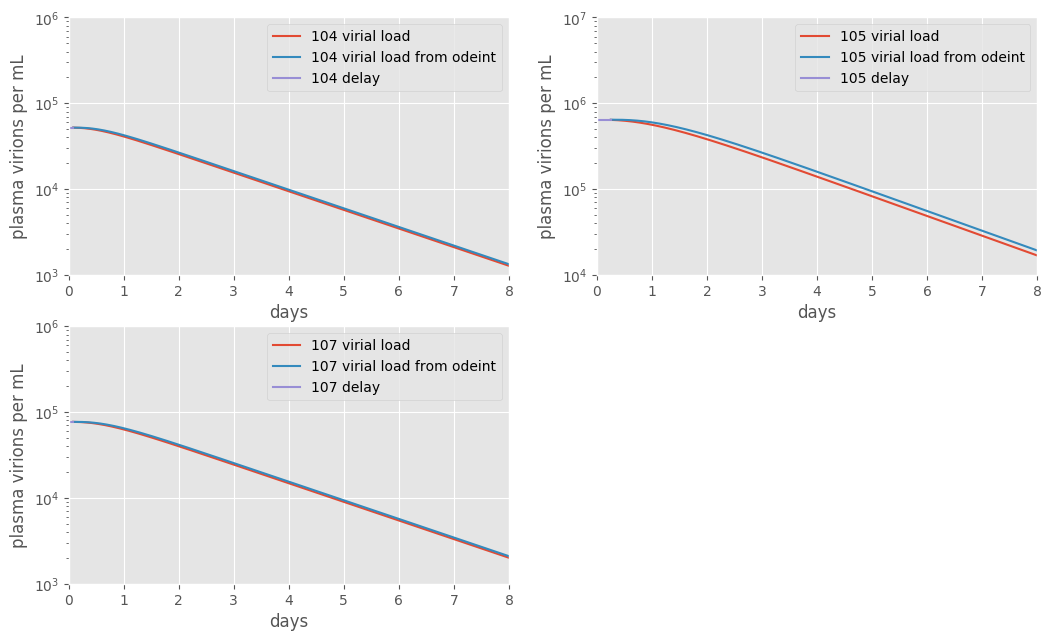

In [9]:
plt.figure(2, figsize=(12.5, 7.5), dpi=100)

plt.subplot(2,2,1)
plt.plot(patient_104_days, V_total_from_eq_6(patient_104_days, patient_104_parameter_array), label="104 virial load")
plt.plot(patient_104_days, patient104VirialLoad, label="104 virial load from odeint")
plt.plot([0,patient_104_delay], [patient_104_parameter_array[0], patient_104_parameter_array[0]], label="104 delay")
plt.ylim(10**3, 10**6)
plt.yscale('log')
plt.xlim(0, 8)
plt.xlabel('days')
plt.legend()
plt.ylabel('plasma virions per mL')

plt.subplot(2,2,2)
plt.plot(patient_105_days, V_total_from_eq_6(patient_105_days, patient_105_parameter_array), label="105 virial load")
plt.plot(patient_105_days, patient105VirialLoad, label="105 virial load from odeint")
plt.plot([0,patient_105_delay], [patient_105_parameter_array[0], patient_105_parameter_array[0]], label="105 delay")
plt.ylim(10**4, 10**7)
plt.yscale('log')
plt.xlim(0, 8)
plt.xlabel('days')
plt.legend()
plt.ylabel('plasma virions per mL')

plt.subplot(2,2,3)
plt.plot(patient_107_days, V_total_from_eq_6(patient_107_days, patient_107_parameter_array), label="107 virial load")
plt.plot(patient_107_days, patient107VirialLoad, label="107 virial load from odeint")
plt.plot([0,patient_107_delay], [patient_107_parameter_array[0], patient_107_parameter_array[0]], label="107 delay")
plt.ylim(10**3, 10**6)
plt.yscale('log')
plt.xlim(0, 8)
plt.xlabel('days')
plt.legend()
plt.ylabel('plasma virions per mL')

plt.show()

#### iv. Are the results the same as in (1)?

Show evidence of your conclusion.

Ks_2sampResult(statistic=0.01100000000000001, pvalue=0.99999998230310694)
Ks_2sampResult(statistic=0.033000000000000029, pvalue=0.64060501846211892)
Ks_2sampResult(statistic=0.01100000000000001, pvalue=0.99999998230310694)


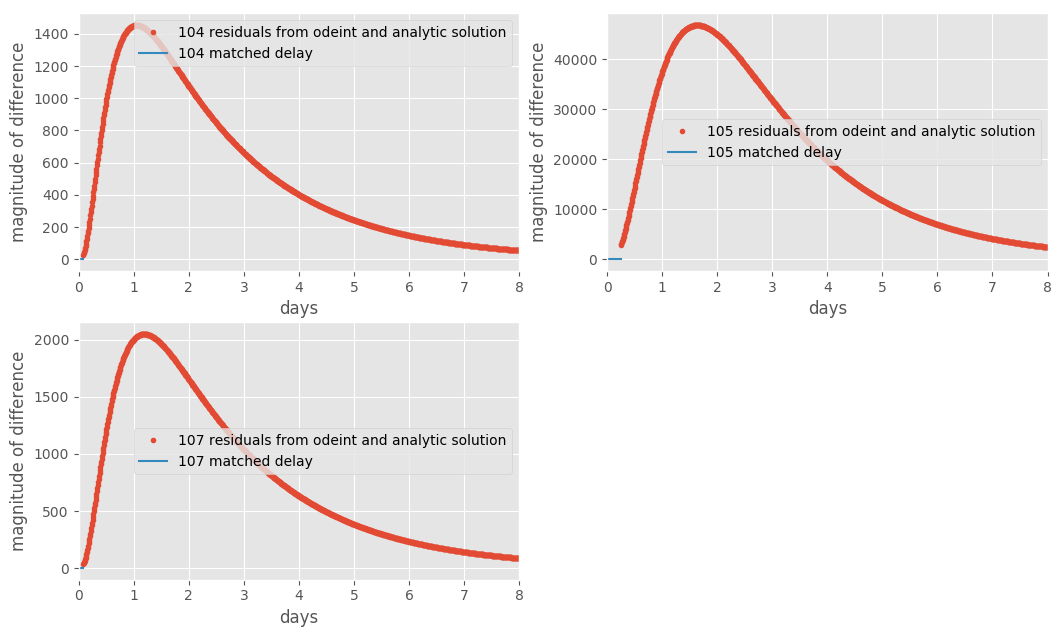

In [10]:
import scipy
from scipy import stats

print(scipy.stats.ks_2samp(patient104VirialLoad, V_total_from_eq_6(patient_104_days, patient_104_parameter_array)))
print(scipy.stats.ks_2samp(patient105VirialLoad, V_total_from_eq_6(patient_105_days, patient_105_parameter_array)))
print(scipy.stats.ks_2samp(patient107VirialLoad, V_total_from_eq_6(patient_107_days, patient_107_parameter_array)))


plt.figure(3, figsize=(12.5, 7.5), dpi=100)

plt.subplot(2,2,1)
plt.plot(patient_104_days, abs(patient104VirialLoad-V_total_from_eq_6(patient_104_days, patient_104_parameter_array)),'.', label='104 residuals from odeint and analytic solution')
plt.plot([0,patient_104_delay], [0, 0], label='104 matched delay')
plt.xlim(0, 8)
plt.legend()
plt.xlabel('days')
plt.ylabel('magnitude of difference')

plt.subplot(2,2,2)
plt.plot(patient_105_days, abs(patient105VirialLoad-V_total_from_eq_6(patient_105_days, patient_105_parameter_array)), '.', label='105 residuals from odeint and analytic solution')
plt.plot([0,patient_105_delay], [0, 0], label='105 matched delay')
plt.xlim(0, 8)
plt.legend()
plt.xlabel('days')
plt.ylabel('magnitude of difference')

plt.subplot(2,2,3)
plt.plot(patient_107_days, abs(patient107VirialLoad-V_total_from_eq_6(patient_107_days, patient_107_parameter_array)), '.', label='107 residuals from odeint and analytic solution')
plt.plot([0,patient_107_delay], [0, 0], label='107 matched delay')
plt.xlim(0, 8)
plt.legend()
plt.xlabel('days')
plt.ylabel('magnitude of difference')

plt.show()

0.998028315488
0.985219526945
0.998158481012


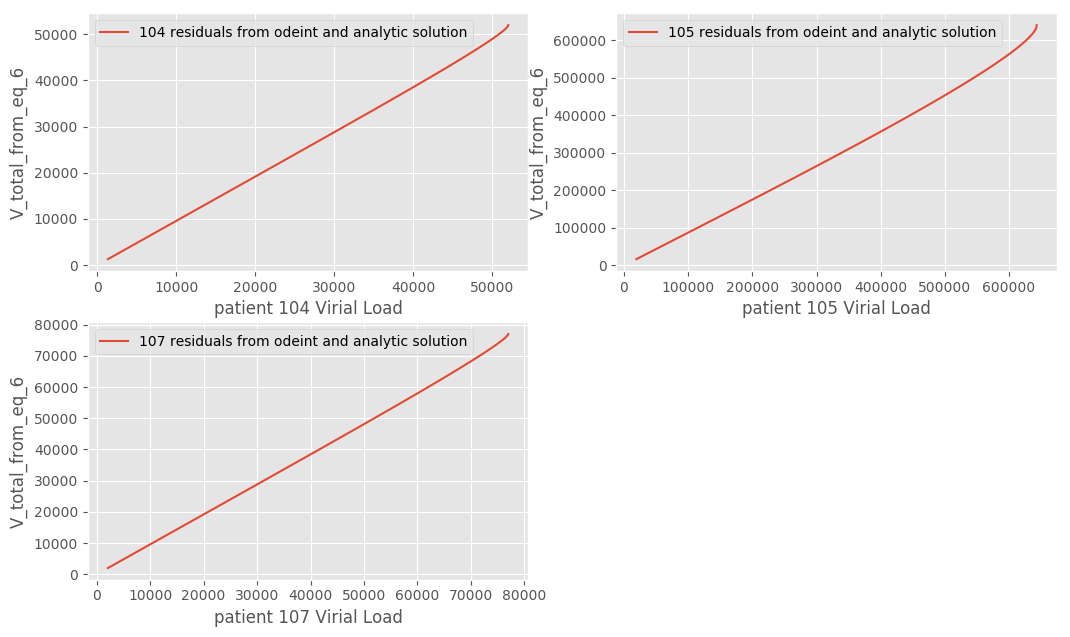

In [23]:
import sklearn
from sklearn import metrics

print(sklearn.metrics.r2_score(patient104VirialLoad, V_total_from_eq_6(patient_104_days, patient_104_parameter_array)))
print(sklearn.metrics.r2_score(patient105VirialLoad, V_total_from_eq_6(patient_105_days, patient_105_parameter_array)))
print(sklearn.metrics.r2_score(patient107VirialLoad, V_total_from_eq_6(patient_107_days, patient_107_parameter_array)))

plt.figure(4, figsize=(12.5, 7.5), dpi=100)

plt.subplot(2,2,1)
plt.plot(patient104VirialLoad, V_total_from_eq_6(patient_104_days, patient_104_parameter_array), label='104 residuals from odeint and analytic solution')
plt.legend()
plt.xlabel('patient 104 Virial Load')
plt.ylabel('V_total_from_eq_6')

plt.subplot(2,2,2)
plt.plot(patient105VirialLoad, V_total_from_eq_6(patient_105_days, patient_105_parameter_array), label='105 residuals from odeint and analytic solution')
plt.legend()
plt.xlabel('patient 105 Virial Load')
plt.ylabel('V_total_from_eq_6')

plt.subplot(2,2,3)
plt.plot(patient107VirialLoad, V_total_from_eq_6(patient_107_days, patient_107_parameter_array), label='107 residuals from odeint and analytic solution')
plt.legend()
plt.xlabel('patient 107 Virial Load')
plt.ylabel('V_total_from_eq_6')

plt.show()

Having KS p-values near one validates that these two series are very close to each other. The data and base line measurements are large and cause some trouble for patient 105, but the other two patients exhibit close similarity to their numerical results.

### (3) Repeat the work that the authors describe in item 12 of their “References and Notes”.

#### (i) Namely, vary the effectiveness factor of the drug (η=1.0, 0.99, 0.95, and 0.90) and simulate the viral load that would result from the modified differential equations using the parameters c=3.0 days-1 and δ=0.5 days-1 as described in item 12 and the values of T0, V0, and the time delay provided for patient 105.

In [10]:
def badsystemPostDrug(vars_array_Tstar_T_VI_VNI, t_time, parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N, eta):
    
    T_star = vars_array_Tstar_T_VI_VNI[0]
    T = vars_array_Tstar_T_VI_VNI[1]
    V_I = vars_array_Tstar_T_VI_VNI[2]
    V_NI = vars_array_Tstar_T_VI_VNI[3]
    
    c_clearance = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N[1]
    delta_loss = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N[2]
    T_total = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N[3]
    k_infection = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N[4]
    N = parameter_array_V0_cClearance_deltaLoss_Ttotal_kInfection_N[5]
    
    
    d_T_star__d_t = (k_infection * V_I * T) - (delta_loss * T_star)
    
    d_T__d_t = (-1 * d_T_star__d_t)
    
    d_V_I__d_t = (1-eta)*(N*delta_loss*T_star)+(-1 * c_clearance * V_I) #4
    
    d_V_NI__d_t = (eta)*(N * delta_loss * T_star) - (c_clearance * V_NI) #5
    
    
    d_vars_array_Tstar_T_VI_VNI__dt = [d_T_star__d_t, d_T__d_t, d_V_I__d_t, d_V_NI__d_t]
    
    return(d_vars_array_Tstar_T_VI_VNI__dt)

patient_105_parameter_array_expanded_augmented = patient_105_parameter_array_expanded
patient_105_parameter_array_expanded_augmented[1] = 3
patient_105_parameter_array_expanded_augmented[2] = 0.5

eta_vary_array = []

import time

start = time.time()
print("hello")

for eta in [1, 0.99, 0.95, 0.90]:
    sol105_baddrug = odeint(badsystemPostDrug, 
                            steady_state_array_Tstarsteady_Tsteady_V0_105, 
                            patient_105_days, 
                            args=(patient_105_parameter_array_expanded_augmented, eta))
    patient105VirialLoad_bad = [sum(x) for x in zip(sol105_baddrug[:, 2],sol105_baddrug[:, 3])]
    eta_vary_array.append(patient105VirialLoad_bad)

eta_vary_array = np.asarray(eta_vary_array).T
end = time.time()
print("{} seconds".format(end - start))
print(eta_vary_array)

hello
0.013031005859375 seconds
[[ 643000.          643000.          643000.          643000.        ]
 [ 637791.23275758  637791.23374685  637791.23770291  637791.24264832]
 [ 632703.60766574  632703.61547764  632703.64672543  632703.68578463]
 ..., 
 [  12679.01790532   13053.21807288   14650.59518782   16891.67677969]
 [  12629.93279296   13003.1158845    14596.28290466   16831.78359969]
 [  12581.03770702   12953.20600545   14542.17197862   16772.10281585]]


#### (ii) Then, use the function scipy.optimize.leastsq to fit this data to the equation for V(t) given in the paper and find the estimates of c and δ that result. Fit only the portion of the curve after the pharmacokinetic delay. Compare these estimates to the actual values for c and δ and discuss the consequences of an imperfect drug on clearance time estimates.

In [11]:
def lst_V_total_from_eq_6(t_time, V_0pl, parameter_array_cClearance_deltaLoss):
    
    V_0 = V_0pl
    c_clearance = parameter_array_cClearance_deltaLoss[0]
    delta_loss = parameter_array_cClearance_deltaLoss[1]
    
    exp_negative_c_times_t = np.exp(-1 * c_clearance * t_time)
    negative_delta_times_t = -1* delta_loss * t_time
    exp_negative_delta_times_t = np.exp(negative_delta_times_t)
    c_over_c_minus_delta = c_clearance / (c_clearance - delta_loss)
    
    V_total = (V_0 * exp_negative_c_times_t) + (V_0 * c_over_c_minus_delta) * (c_over_c_minus_delta * (exp_negative_delta_times_t - exp_negative_c_times_t) + (negative_delta_times_t * exp_negative_c_times_t))
    
    return(np.log(V_total))

def residuals(model_parametersq, y_dataq, input_valuesq):
    output_valuesq = []
    for i in range(len(input_valuesq)):
        output_valuesq.append(lst_V_total_from_eq_6(input_valuesq[i], (643 * 10**3), model_parametersq))
    
    return([(y_actual - y_predicted) for y_actual, y_predicted in (zip(y_dataq, output_valuesq))])

X0 = [2.06, 0.53]

lstsqr_solution1 = scipy.optimize.least_squares(residuals, X0, args=(np.log(eta_vary_array[:,0]), patient_105_days))
lstsqr_solution2 = scipy.optimize.least_squares(residuals, X0, args=(np.log(eta_vary_array[:,1]), patient_105_days))
lstsqr_solution3 = scipy.optimize.least_squares(residuals, X0, args=(np.log(eta_vary_array[:,2]), patient_105_days))
lstsqr_solution4 = scipy.optimize.least_squares(residuals, X0, args=(np.log(eta_vary_array[:,3]), patient_105_days))

print(lstsqr_solution1.x)
print(lstsqr_solution2.x)
print(lstsqr_solution3.x)
print(lstsqr_solution4.x)

[ 22.01859983   0.49652088]
[ 23.68862135   0.4924995 ]
[ 34.57814165   0.47653319]
[ 90.01700453   0.45683369]


The delta values (second value in the arrays above) follow the same trend as mentioned in the paper. "delta = 0.500, 0.494, 0.470, 0.441"
In general these values decrease since it is the rate of loss of virus producing cells . The more ineffective a drug is, the longer a virus producing cell gets to exist.

My c values are exploding as I run least squares and I don't know why. I have a feeling it is because c is both on the denominator and numerator of a fraction (where when c becomes high, the numerator cancels out with the denominator and becomes ~1 and dimishes the effect of delta) and it's negative as an argument in several exponentials (where when c becomes high, the overall value also becomes small~0) so there is a lot of value in optimizing by making c high. In terms of pharmacokinetics, we know that c relates to the rate of virion clearance. The larger the c, the shorter it takes for the body to eject the virion. In theory, the more ineffective a drug is, the smaller c gets, since it follows the same type of philosophy as delta. However, the study showed that c barely changes from its original value of 0.3 inverse days.

#### (iii) Examine the residual plots from your fits to determine whether or not there is a trend in the error associated with fitting these new curves.

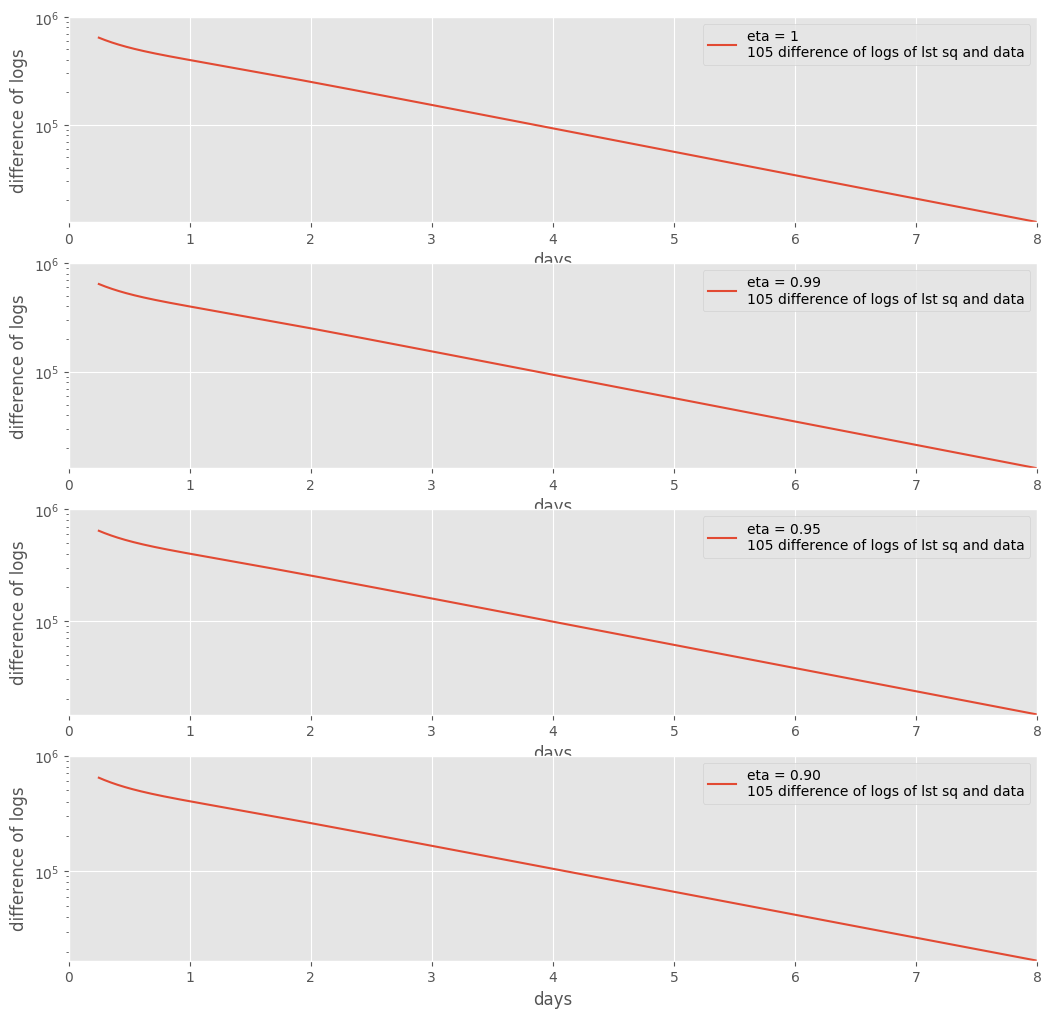

In [12]:
# for eta in [1, 0.99, 0.95, 0.90]:

plt.figure(2, figsize=(12.5, 12.5), dpi=100)
plt.subplot(411)
plt.plot(patient_105_days, residuals(lstsqr_solution1.x, eta_vary_array[:,0], patient_105_days), label="eta = 1 \n105 difference of logs of lst sq and data")
plt.yscale('log')
plt.xlim(0, 8)
plt.ylim(0, 10**6)
plt.legend()
plt.xlabel('days')
plt.ylabel('difference of logs')

plt.subplot(412)
plt.plot(patient_105_days, residuals(lstsqr_solution2.x, eta_vary_array[:,1], patient_105_days), label="eta = 0.99 \n105 difference of logs of lst sq and data")
plt.yscale('log')
plt.xlim(0, 8)
plt.ylim(0, 10**6)
plt.legend()
plt.xlabel('days')
plt.ylabel('difference of logs')

plt.subplot(413)
plt.plot(patient_105_days, residuals(lstsqr_solution3.x, eta_vary_array[:,2], patient_105_days), label="eta = 0.95 \n105 difference of logs of lst sq and data")
plt.yscale('log')
plt.xlim(0, 8)
plt.ylim(0, 10**6)
plt.legend()
plt.xlabel('days')
plt.ylabel('difference of logs')

plt.subplot(414)
plt.plot(patient_105_days, residuals(lstsqr_solution4.x, eta_vary_array[:,3], patient_105_days), label="eta = 0.90 \n105 difference of logs of lst sq and data")
plt.yscale('log')
plt.xlim(0, 8)
plt.ylim(0, 10**6)
plt.legend()
plt.xlabel('days')
plt.ylabel('difference of logs')

plt.show()

The error decreases logarithmically as the time increases. We should be seeing a nonrandom patter in our residuals if our fit was a good fit. Here we see since the residuals are not distributed normally and have a different kind of distribution which should be expected from nonlinear least squares.

### (4) To determine the TCID50 one should estimate an infectivity coefficient.

To calculate the infectivity coefficient, estimate the ratio of VI(t=0) to the value of TCID50(t=0) for patient 105 from Perelson’s Figure 1. This coefficient acts as a conversion factor between the number of virions in the infectious pool, VI, and the TCID50, and is an indicator of the efficiency of the HIV-1 transmission.

In [13]:
# Answer

### (Bonus) Reimplement 3ii solving the system of differential equations using the matrix exponential. Compare the performance of using odeint versus the matrix exponential.

In [14]:
steadystar, steadyT, steadyV0, z0forVNI = steady_state_array_Tstarsteady_Tsteady_V0_105
x0_ivp = np.asarray([steadystar, steadyV0, z0forVNI])
x0_ivp = np.reshape(x0_ivp, (3,1))


startex = time.time()
print("hello")
eta_viral_holder = []
for eta in [1, 0.99, 0.95, 0.90]:
    eta_sol = []
    for i in patient_105_days:
        Jacobian = np.asarray([[-1*0.5, patient_105_parameter_array_expanded_augmented[4]*steadyT,0],
                           [(1-eta)*0.5*patient_105_parameter_array_expanded_augmented[5],-1*3,0],
                           [eta*0.5*patient_105_parameter_array_expanded_augmented[5],0,-1*3]])
        expmat = scipy.linalg.expm(Jacobian*(i-patient_105_days[0]))
        eta_sol.append(np.reshape(np.matmul(expmat,x0_ivp), (3,)))
    eta_sol = np.asarray(eta_sol)
    patient105VirialLoad_bad_exp = eta_sol[:,1] + eta_sol[:,2]
    eta_viral_holder.append(patient105VirialLoad_bad_exp)

eta_viral_holder = np.asarray(eta_viral_holder).T
endex = time.time()
print("{} seconds".format(endex - startex))

lstsqr_solution5 = scipy.optimize.least_squares(residuals, X0, args=(np.log(eta_viral_holder[:,0]), patient_105_days))
lstsqr_solution6 = scipy.optimize.least_squares(residuals, X0, args=(np.log(eta_viral_holder[:,1]), patient_105_days))
lstsqr_solution7 = scipy.optimize.least_squares(residuals, X0, args=(np.log(eta_viral_holder[:,2]), patient_105_days))
lstsqr_solution8 = scipy.optimize.least_squares(residuals, X0, args=(np.log(eta_viral_holder[:,3]), patient_105_days))

print(lstsqr_solution5.x)
print(lstsqr_solution6.x)
print(lstsqr_solution7.x)
print(lstsqr_solution8.x)

hello
1.5689244270324707 seconds
[ 22.14122758   0.49658645]
[ 23.73838093   0.49268225]
[ 33.87639061   0.47717124]
[ 79.05756644   0.4580103 ]


First I calculated the Jacobian on paper by taking the derivative of each derivative with respect to a certain variable. This is the same technique used to linearize it around an equilibrium point. Had I maintained using the original four equations (the original 3: $T^*$, $V_I$, and $V_{NI}$ along with $T$, then the Jacobian just becomes a matrix with the same values as above but with the second column and the second row filled with $0$s. This is why my exponential matrix method ignores $T$ and is 3x3 and not 4x4.
I then subjected the Jacobian to a for loop where the $\eta$ parameter changes. Since the Jacobian times the time value has to be exponentiated I placed another for loop to iterate through time points. I also had to "move" it by subtracting the initial time point. This new exponential matrix then has to multiply by the steady state values to produce the values we are looking for. Each of these successive matrix multiplications, successive for loops, array to list and list to array manipulations, makes this method cumbersome. I also timed it and and the matrix exponential method (>1.5 seconds) took so much longer (an entire second longer) than the odeint (~0.01 seconds). Also odeint is based on a Fortran library which may be faster.

However, this method should be faster, for much larger systems.

Unfortunately, my least squares is still giving me large c's regardless of method used to obtain the data. This verifies that it is a problem with least squares and the optimization process.